<a href="https://colab.research.google.com/github/Mayakshanesht/Autonomous_Driving_Lecture_resources/blob/Perception/Yolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import os
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
os.chdir("/content/drive/My Drive/YOLO")
!ls

coco.names  mayur1.jpg	       rohit.png   yolov3.weights
Data	    mayur_profile.jpg  yolov3.cfg


In [12]:
!pip install opencv-python==4.5.2.52

In [13]:
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [14]:
class YOLO():
  """
  write a constructor to set up a model using OPENCV DNN library
  """
  def __init__(self):
    self.confThreshold=0.4
    self.nmsThreshold=0.5
    self.inpWidth=416
    self.inpHeight=416
    self.classes=[]
    classesfile="/content/drive/My Drive/YOLO/Data/coco.names"
    with open(classesfile,'rt') as f:
      self.classes=f.read().rstrip('\n').split('\n')
    modelConfiguration="/content/drive/My Drive/YOLO/Data/yolov3.cfg"
    modelWeights="/content/drive/My Drive/YOLO/Data/yolov3.weights"
    self.i=0
    self.net=cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
    self.net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
    self.net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

  #get output layer names
  def getOutputsNames(self):
    layerNames=self.net.getLayerNames()
    return [layerNames[i[0]-1] for i in self.net.getUnconnectedOutLayers()]
  
  def drawPred(self, frame, classId, conf, left, top, right, bottom):
    '''
    Draw a bounding box around a detected object given the box coordinates
    Later, we could repurpose that to display an ID
    '''
    # Draw a bounding box.
    cv.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), thickness=5)
    label = '%.2f' % conf
    # Get the label for the class name and its confidence
    if self.classes:
        assert(classId < len(self.classes))
        label = '%s:%s' % (self.classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=3)
    return frame

  def postprocess(self,frame, outs):
    """
    Postprocessing step. Take the output out of the neural network and interpret it.
    We should use that output to apply NMS thresholding and confidence thresholding
    We should use the output to draw the bounding boxes using the dramPred function
    """
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    classIds = []
    confidences = []
    boxes = []
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > self.confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])
    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv.dnn.NMSBoxes(boxes, confidences, self.confThreshold, self.nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        output_image = self.drawPred(frame,classIds[i], confidences[i], left, top, left + width, top + height)
    return output_image
  

  
  def inference(self,image):
      """
      Main loop.
      Input: Image
      Output: Frame with the drawn bounding boxes
      """
      # Create a 4D blob from a frame.
      blob = cv.dnn.blobFromImage(image, 1/255, (self.inpWidth, self.inpHeight), [0,0,0], 1, crop=False)
      # Sets the input to the network
      self.net.setInput(blob)
      # Runs the forward pass to get output of the output layers
      outs = self.net.forward(self.getOutputsNames())
      # Remove the bounding boxes with low confidence
      final_frame = self.postprocess(image, outs)
      self.i +=1
      return final_frame


    



(432, 768, 3)


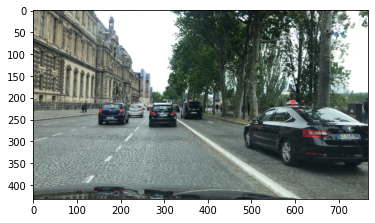

In [15]:
import pickle
dataset_images = pickle.load(open('/content/drive/My Drive/YOLO/Data/images_tracking.p', "rb"))
img =dataset_images[0]
plt.imshow(img)
print(img.shape)

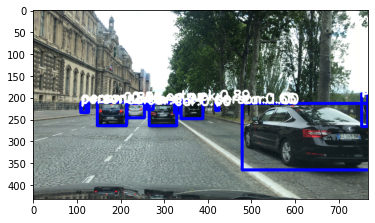

In [16]:
 #mpimg.imread("/content/drive/My Drive/YOLO/mayur1.jpg")
yolo = YOLO()
oi = yolo.inference(img)
plt.imshow(oi)
plt.show()

In [17]:
yolo=YOLO()

In [18]:
a=yolo.getOutputsNames()
print(a)

['yolo_82', 'yolo_94', 'yolo_106']
